# 4. Model Training & XAI (Entrenamiento y Explicabilidad)

**Objetivo:** Entrenar un modelo clasificador (XGBoost) para distinguir entre texto Humano y generado por IA, y utilizar la teoría de Juegos (SHAP Values) para explicar las decisiones del modelo.

**Referencias Teóricas:**
* Se utiliza **XGBoost** por su alto rendimiento en datos estructurados.
* Se aplica **SHAP (SHapley Additive exPlanations)** para descomponer la predicción y entender la contribución marginal de cada característica lingüística (Varianza, riqueza léxica, etc.).

## 4.1. Configuración Inicial

Importar las librerías necesarias (`xgboost` para el modelo, `shap` para explicabilidad, `sklearn` para métricas) y configurar el entorno de trabajo.

Establecemos un estilo visual para los gráficos (`seaborn-whitegrid`) y definimos las rutas de archivos críticas: la entrada (datos procesados) y la salida (donde se guardará el modelo entrenado).

In [4]:
# Instalación de librerías si no están presentes
#%pip install xgboost shap 

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import shap
import matplotlib.pyplot as plt
import joblib
import os

# Configuración para que los gráficos se vean bien
plt.style.use('seaborn-v0_8-whitegrid')

# Rutas
INPUT_FILE = '../data/2_processed/training_data_final.csv'
MODEL_DIR = '../models/'
MODEL_PATH = '../models/xgboost_classifier.pkl'

print("✅ Librerías cargadas y entorno configurado.")

✅ Librerías cargadas y entorno configurado.


## 4.2. Carga y Preparación de Datos

Cargar el dataset procesado (`training_data_final.csv`) y separar las características predictivas ($X$) de la variable objetivo ($y$).


1. Eliminamos columnas no predictivas como `original_id` o fragmentos de texto para evitar el "Data Leakage" (el modelo no debe memorizar IDs).
2. Verificamos la distribución de clases (Humano vs. IA) para asegurar que el dataset está equilibrado.

In [16]:
# 1. Cargar el dataset procesado
df = pd.read_csv(INPUT_FILE)

print(f"📂 Dataset cargado: {df.shape}")
print(f"   Distribución: {df['label'].value_counts().to_dict()} (0=Humano, 1=IA)")

# 2. Limpieza de columnas NO predictivas
# Es CRÍTICO eliminar 'original_id' y textos para evitar "Data Leakage" (trampas)
cols_to_drop = ['label', 'original_id', 'text_snippet', 'article', 'title_ref']
# Filtramos solo las que existan en el DF
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

X = df.drop(cols_to_drop, axis=1)
y = df['label']

print("\n📋 Features (Características) que usará el modelo:")
print(list(X.columns))

📂 Dataset cargado: (9997, 14)
   Distribución: {0: 4999, 1: 4998} (0=Humano, 1=IA)

📋 Features (Características) que usará el modelo:
['word_count', 'avg_sentence_length', 'sent_len_std', 'lexical_diversity', 'stopword_ratio', 'adj_ratio', 'verb_ratio', 'noun_ratio', 'entity_ratio', 'sentiment_polarity', 'sentiment_subjectivity', 'reading_ease']


## 4.3. División y Entrenamiento (XGBoost)

Dividir los datos en conjuntos de Entrenamiento (80%) y Prueba (20%), y entrenar el Clasificador XGBoost.


1. Usamos `train_test_split` con `stratify=y` para mantener la proporción de clases en ambos grupos.
2. Configuramos `XGBClassifier` con hiperparámetros diseñados para evitar el sobreajuste (ej. `max_depth=6`, `subsample=0.8`).
3. Ejecutamos el entrenamiento con `.fit()`.

In [37]:
# 1. Split Train/Test (80% entrenamiento, 20% test)
# stratify=y asegura que haya la misma proporción de IA/Humano en ambos grupos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"⚙️ Entrenando con {X_train.shape[0]} muestras...")

# 2. Definición del Modelo XGBClassifier
# Hemos quitado 'use_label_encoder' porque en versiones nuevas ya no es necesario
model = xgb.XGBClassifier(
    n_estimators=300,        # Número de árboles
    learning_rate=0.06,      # Paso de aprendizaje
    max_depth=6,             # Profundidad máxima
    subsample=0.8,           # Evita overfitting (80% datos)
    colsample_bytree=0.8,    # Evita overfitting (80% columnas)
    eval_metric='logloss',   # Métrica de evaluación interna
    random_state=42
)

# 3. Entrenamiento
model.fit(X_train, y_train)

print("✅ ¡Modelo entrenado exitosamente!")

⚙️ Entrenando con 7997 muestras...
✅ ¡Modelo entrenado exitosamente!


## 4.4. Evaluación del Modelo

Evaluar el rendimiento del modelo con datos que nunca ha visto (Conjunto de Test).


1. Generamos predicciones (`y_pred`).
2. Calculamos la **Accuracy** (precisión global) y el **F1-Score** (equilibrio entre precisión/recall).
3. Mostramos la **Matriz de Confusión** para ver cuántos textos Humanos se confundieron con IA y viceversa.

In [38]:
# Predicciones en el conjunto de Test (que el modelo nunca ha visto)
y_pred = model.predict(X_test)

# Métricas
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n🎯 RESULTADOS DEL MODELO:")
print(f"   Accuracy: {acc:.4f} ({(acc*100):.2f}%)")
print(f"   F1-Score: {f1:.4f}")
print("-" * 30)
print("Informe detallado:")
print(classification_report(y_test, y_pred, target_names=['Humano', 'IA']))

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))


🎯 RESULTADOS DEL MODELO:
   Accuracy: 0.9065 (90.65%)
   F1-Score: 0.9065
------------------------------
Informe detallado:
              precision    recall  f1-score   support

      Humano       0.91      0.91      0.91      1000
          IA       0.91      0.91      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000

Matriz de Confusión:
[[906  94]
 [ 93 907]]


## 4.5. Guardado del Modelo

Guardar el modelo entrenado en un archivo para que pueda ser cargado luego por la App de Streamlit.

Usamos `joblib.dump()` para crear el archivo `xgboost_classifier.pkl` en el directorio `models/`.

In [39]:
# Guardamos el modelo entrenado para usarlo luego en la Web App
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

joblib.dump(model, MODEL_PATH)
print(f"\n💾 Modelo guardado en: {MODEL_PATH}")


💾 Modelo guardado en: ../models/xgboost_classifier.pkl


# 4.6. Sección XAI (Explainable AI)

Según la teoría del curso, usamos **SHAP Values** para entender el impacto global de cada variable.
Usaremos el `TreeExplainer`, optimizado para modelos de árboles como XGBoost.

* **Gráfico Beeswarm:** Muestra qué variables son más importantes y cómo sus valores (altos/bajos) empujan hacia la clase IA (1) o Humano (0).

## 4.6. Explainable AI (XAI): Análisis Global

Calcular los valores SHAP para entender qué características impulsan las decisiones del modelo a nivel global.


1. Creamos un `TreeExplainer`.
2. Generamos el **Gráfico Beeswarm**. Este gráfico es crucial: muestra las variables más importantes (de arriba a abajo) y cómo sus valores (Alto=Rojo, Bajo=Azul) impactan en la predicción (Derecha=IA, Izquierda=Humano).

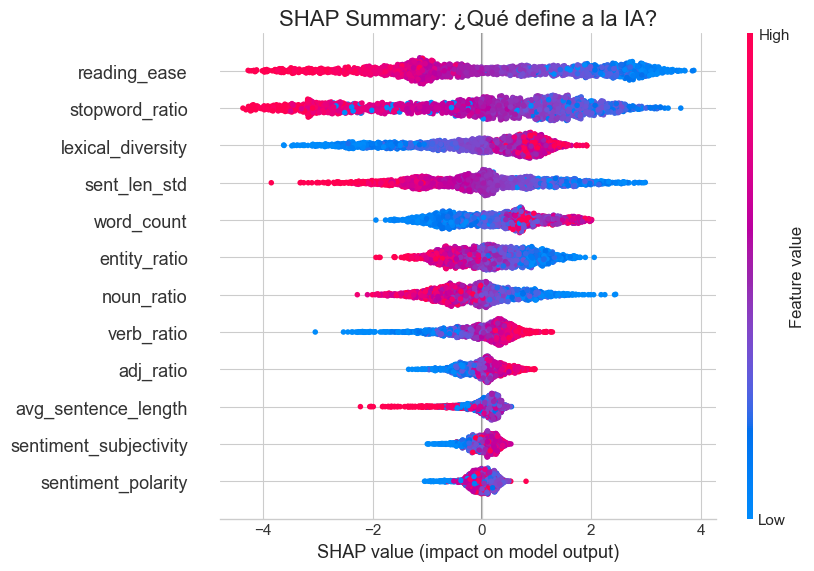

In [40]:
# 1. Crear el Explainer
explainer = shap.TreeExplainer(model)

# 2. Calcular los valores SHAP para el set de test
shap_values = explainer(X_test)

# 3. Visualización Global (Beeswarm)
plt.figure(figsize=(10, 6))
plt.title("SHAP Summary: ¿Qué define a la IA?", fontsize=16)
shap.plots.beeswarm(shap_values, max_display=12, show=True)

## 4.6.2. Explicabilidad Local (Caso de Estudio)

Analizar *por qué* un artículo específico fue clasificado como IA.

Seleccionamos una instancia concreta (predicha como IA) y generamos un **Waterfall Plot**. Esto muestra cómo cada característica suma (+ rojo) o resta (- azul) probabilidad desde el valor base hasta llegar a la puntuación final.

🔍 Explicando predicción para la muestra índice 3 (Predicción: IA)


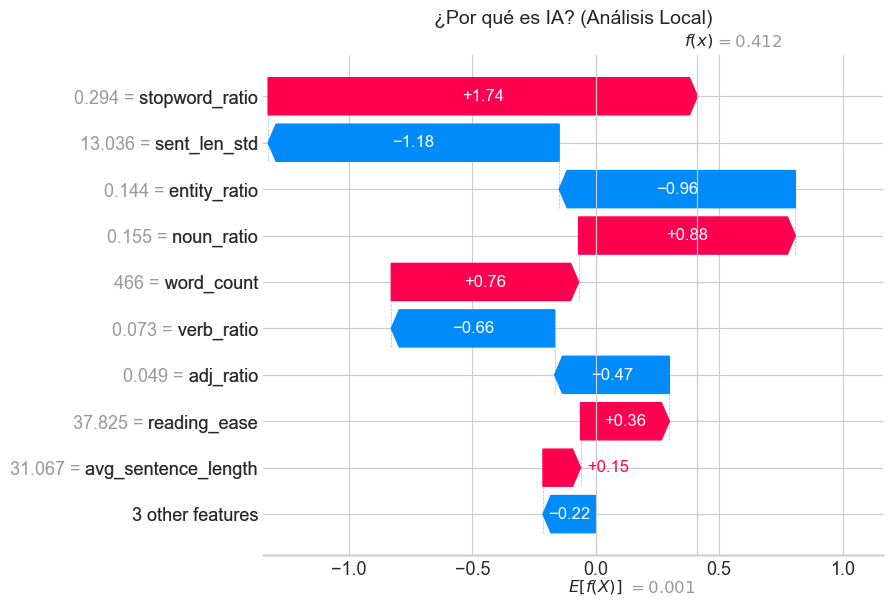

In [41]:
# Elegimos un ejemplo que el modelo haya clasificado como IA (Clase 1)
# Buscamos en y_pred dónde hay un 1
ai_indices = np.where(y_pred == 1)[0]

if len(ai_indices) > 0:
    idx_to_explain = ai_indices[0] # Cogemos el primero que encontremos
    
    print(f"🔍 Explicando predicción para la muestra índice {idx_to_explain} (Predicción: IA)")
    
    # Waterfall Plot
    plt.title(f"¿Por qué es IA? (Análisis Local)", fontsize=14)
    shap.plots.waterfall(shap_values[idx_to_explain], max_display=10, show=True)
else:
    print("No se encontraron predicciones de IA en el test set para explicar.")

## 4.6.3. Analisis automático del top 3 features

Identificar automáticamente las 3 características más influyentes y analizar su comportamiento en detalle.


1. Calculamos la importancia media absoluta SHAP para rankear las características.
2. Para el Top 3, generamos:
    * **Scatter Plot:** Para detectar umbrales (ej. "Si Varianza < 5.0 -> IA").
    * **Dependence Plot:** Para ver cómo la característica interactúa con otras.

🏆 Las 3 variables más determinantes son: ['reading_ease', 'stopword_ratio', 'lexical_diversity']
----------------------------------------

🔍 Analizando a fondo: READING_EASE


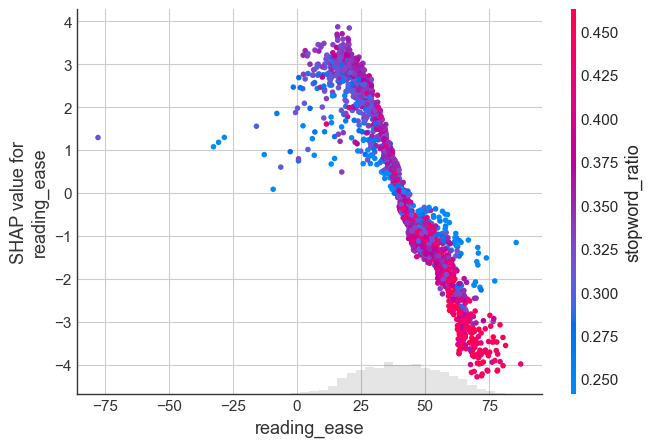

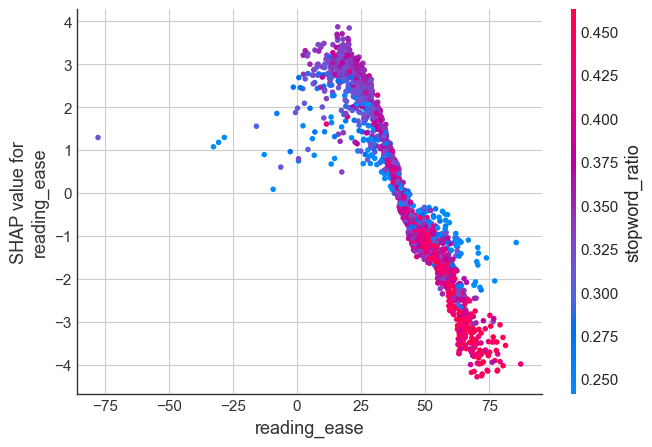


🔍 Analizando a fondo: STOPWORD_RATIO


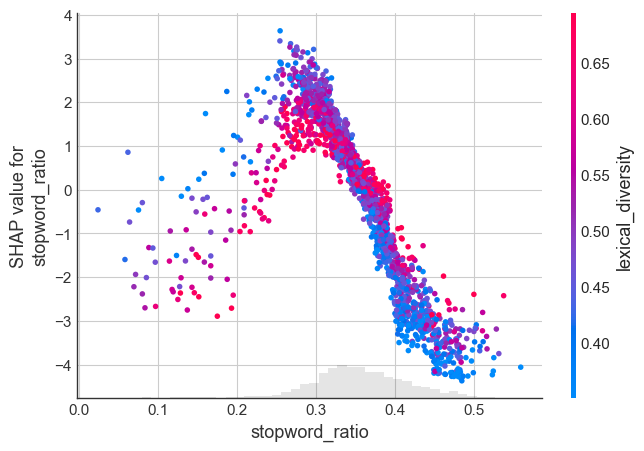

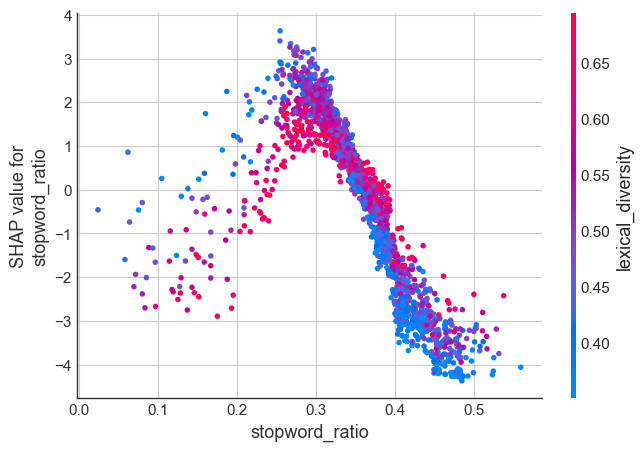


🔍 Analizando a fondo: LEXICAL_DIVERSITY


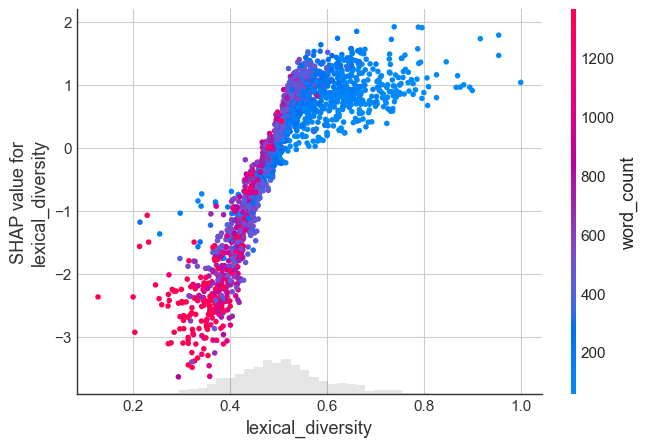

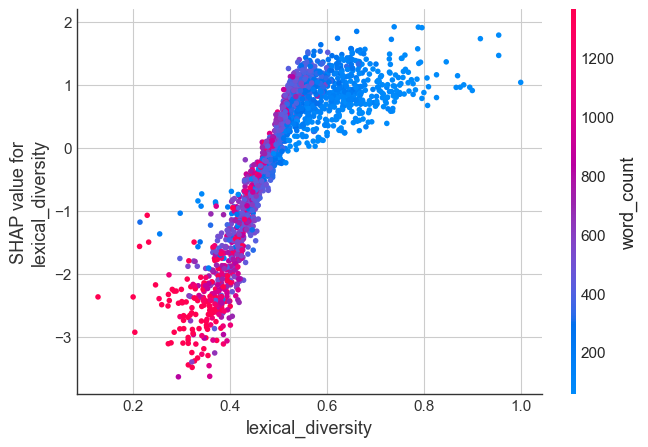

In [42]:
## 4.10. Análisis Automático del TOP 3 Características
# Objetivo: Profundizar solo en lo que realmente importa.

# 1. Obtenemos el ranking de importancia media absoluta
# (Calculamos la media de los valores SHAP absolutos para cada columna)
feature_importance = np.abs(shap_values.values).mean(0)
feature_names = X_test.columns

# Creamos un DataFrame para ordenar
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

# Seleccionamos las 3 reinas
top_3_features = importance_df.head(3)['feature'].tolist()

print(f"🏆 Las 3 variables más determinantes son: {top_3_features}")
print("-" * 40)

# 2. Bucle para generar los gráficos clave de estas 3
for feat in top_3_features:
    print(f"\n🔍 Analizando a fondo: {feat.upper()}")
    
    # A) Gráfico de Dispersión (Scatter) - Para ver umbrales
    # Nos dice: "¿A partir de qué valor exacto esto se considera IA?"
    shap.plots.scatter(shap_values[:, feat], color=shap_values)
    
    # B) Gráfico de Dependencia (Dependence) - Para ver interacciones
    # Nos dice: "¿Cambia el efecto de esta variable si cambia otra?"
    # interaction_index='auto' busca la pareja ideal automáticamente
    shap.dependence_plot(feat, shap_values.values, X_test, interaction_index='auto')

## 4.9. XAI Avanzado: Decision Plot 

**Objetivo:** Visualizar y comparar los "patrones de pensamiento" del modelo para cada clase por separado.

A diferencia de los gráficos anteriores que mostraban mezclas, aquí **filtramos** los datos del conjunto de prueba (`X_test`) para aislar 20 muestras puras de IA y 20 muestras puras de Humanos.

**Observaciones:**
1.  Para las muestras de IA, las líneas convergen hacia la **derecha** (valores SHAP positivos), impulsadas principalmente por la baja varianza (`sent_len_std`) y la complejidad léxica.
2.  Para los textos humanos, las líneas se mueven hacia la **izquierda** (valores SHAP negativos), indicando que su estructura caótica y natural aleja al modelo de la clasificación "artificial".

🔍 Visualizando Decision Plot para 20 muestras VERIFICADAS de IA...


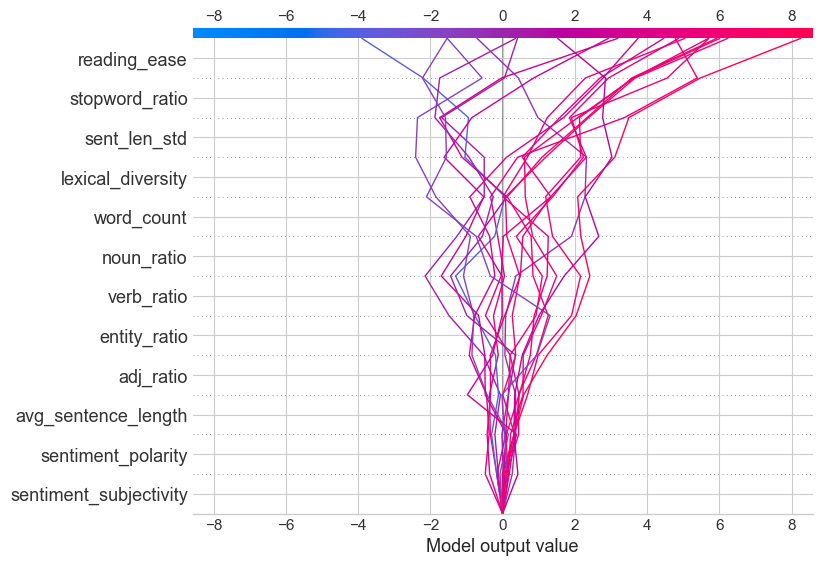

In [43]:
# Seleccionamos los índices en y_test que son realmente IA (Clase 1)
indices_ia = np.where(y_test == 1)[0]

# Seleccionamos solo los primeros 20 de ESOS índices
indices_ia_top20 = indices_ia[:20]

# Filtramos los datos y los valores SHAP usando esos índices
data_ia_only = X_test.iloc[indices_ia_top20]
shap_values_ia_only = shap_values.values[indices_ia_top20]

print(f"🔍 Visualizando Decision Plot para 20 muestras VERIFICADAS de IA...")
shap.decision_plot(explainer.expected_value, shap_values_ia_only, data_ia_only)

🔍 Visualizando Decision Plot para 20 muestras VERIFICADAS de HUMANOS...


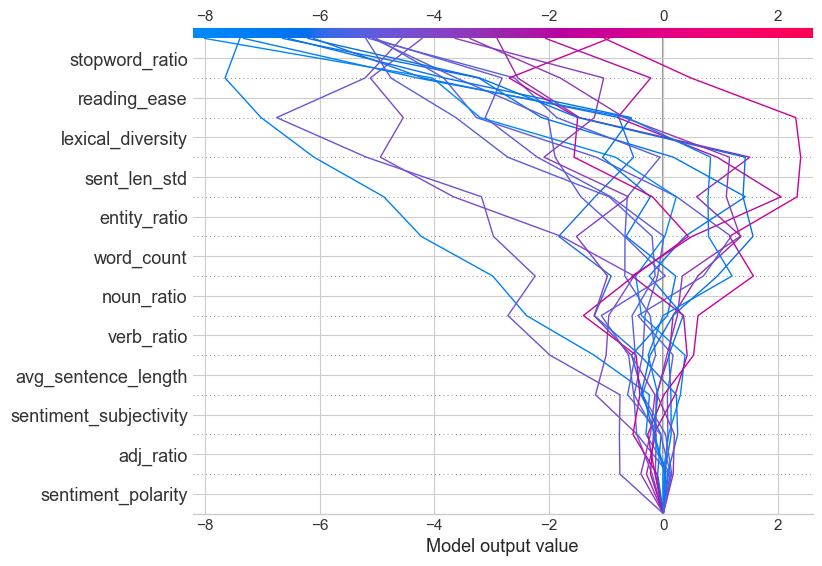

In [44]:
# Encontramos los índices en y_test que son realmente HUMANOS (Clase 0)
indices_human = np.where(y_test == 0)[0]

# Seleccionamos solo los primeros 20 de ESOS índices
indices_human_top20 = indices_human[:20]

# Filtramos los datos y los valores SHAP usando esos índices
data_human_only = X_test.iloc[indices_human_top20]
shap_values_human_only = shap_values.values[indices_human_top20]

print(f"🔍 Visualizando Decision Plot para 20 muestras VERIFICADAS de HUMANOS...")
shap.decision_plot(explainer.expected_value, shap_values_human_only, data_human_only)